# Training a 2-D, Multivariate Convolution Neural Network
### The Necessary Imports

In [2]:
# Initial imports
import numpy as np                                                   # for numpy tools
import pandas as pd                                                  # for DataFrame tools
from pathlib import Path                                             # for writing paths to data files
from TBAC  import StockScrub, VIX_update                             # This line tells python to import the class. Class file should be in same directory as code file
import matplotlib.pyplot as plt
%matplotlib inline
import quandl
import requests
import json
import os
from GoogleNews import GoogleNews

In [3]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

## Reading in the Data Set

In [6]:
apple=StockScrub(["AAPL"])                                                      # creating StockScrub class object for Apple stock analysis
df=apple.data_compile(start="2018-01-01")                                       # combines data from stored DataFrames to be processed for training
df.head()                                                                       # printing first few rows of DataFrame

,close,volume,VIX close
date,,,
2018-01-02,41.440086,25048048.0,10.90
2018-01-03,41.432869,28819653.0,10.70
2018-01-04,41.625323,22211345.0,10.60
2018-01-05,42.099240,23016177.0,10.50
2018-01-08,41.942872,20134092.0,10.49


In [7]:
def window_data_mv(df, window, feature1,feature2, target_col_number):
    """
    This function accepts the column numbers for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []                                                                      # initialize DataFrame for features
    y = []                                                                      # initialize DataFrame for target
    for i in range(len(df) - window):                                           # generates list of indices from start until prior number of steps equal to the window
        features = df.iloc[i : (i + window),feature1:feature2].values                # extracting vectors from DataFrame for features
        target = df.iloc[(i + window), target_col_number]                       # extracting observations from DataFrame for targets
        X.append(features)                                                      # appending extracted vectors to new DataFrame
        y.append(target)                                                        # appeding extracted observations to new DataFrame
    return np.array(X), np.array(y).reshape(-1, 1)                              # converting DataFrames to numpy arrays

In [8]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 7                                                                 # Size of window (can adjust for different trials)

feature1=0                                                                      # defining the column where you want to extract features
feature2=3
target_column = 0                                                               # defining the column where you want to extract targets
X, y = window_data_mv(df, window_size, feature1, feature2, target_column)              # splitting DataFrame into features and targets
X.shape

(747, 7, 3)

In [12]:
from sklearn.preprocessing import StandardScaler                                # importing the StandardScaler
scaler = StandardScaler()                                                       # create an instance to scale the data
X=scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)             #standardize the feature data
split = int(0.8 * len(X))                                                       # specifying 80% split for train-test data
X_train = X[: split - 1]                                                       
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [15]:
# Reshape the features for the model: Dimension representations=(samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 3))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 3))
X_train.shape                                                                   # checking shape of training data tensor

(596, 7, 3)

In [122]:
# Import required Keras modules
from tensorflow.keras.models import Sequential                                    # for building neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout                          # components for LSTM NN

In [123]:
# Define the LSTM RNN model.
model = Sequential()                                                              # Initializing NN

number_units = 7                                                                
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 3))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [124]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [125]:
# Summarize the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 7, 7)              308       
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 7, 7)              420       
_________________________________________________________________
dropout_16 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_17 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [126]:
# Train the model
#pipeline=Pipeline([('scale',scaler),('mod',model)])
history=model.fit(X_train, y_train, epochs=10, shuffle=False, verbose=1)

Epoch 1/10
10/10 [==============================] - 16s 39ms/step - loss: 3190.4955
Epoch 2/10
10/10 [==============================] - 0s 31ms/step - loss: 3177.0365
Epoch 3/10
10/10 [==============================] - 0s 31ms/step - loss: 3163.3450
Epoch 4/10
10/10 [==============================] - 0s 31ms/step - loss: 3147.6325
Epoch 5/10
10/10 [==============================] - 0s 30ms/step - loss: 3128.7321
Epoch 6/10
10/10 [==============================] - 0s 32ms/step - loss: 3103.2443
Epoch 7/10
10/10 [==============================] - 0s 28ms/step - loss: 3072.9832
Epoch 8/10
10/10 [==============================] - 0s 29ms/step - loss: 3029.9385
Epoch 9/10
10/10 [==============================] - 0s 33ms/step - loss: 2985.9707
Epoch 10/10
10/10 [==============================] - 0s 35ms/step - loss: 2946.4597


In [127]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 3s 9ms/step - loss: 12716.0391


12716.0390625

In [128]:
# Make some predictions
predicted = model.predict(X_test)

In [129]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [130]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
date,,
2020-06-29,8516.646082,258.007233
2020-06-30,8587.383627,258.007233
2020-07-01,8571.221738,258.007233
2020-07-02,8571.221738,258.007233
2020-07-06,8799.362033,258.007233


## Plotting Real and Predicted Values of MV-MS-LSTM RNN

<AxesSubplot:title={'center':'Multivariate Multistep LSTM RNN'}, xlabel='date'>

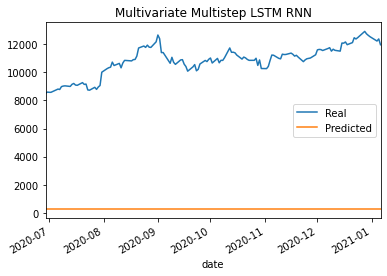

In [131]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Multivariate Multistep LSTM RNN")

## Saving the Model for Future Use

In [108]:
#model.save('MV-MT-LSTM-RNN')